In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # Axes3D import has side effects, it enables using projection='3d' in add_subplot
from mpmath import mp
import matplotlib.patches as mpatches

# For drawing spheres in foreground in Matplotlib 3D plot
import matplotlib
from mpl_toolkits.mplot3d import Axes3D, art3d
from matplotlib.patches import Circle, Ellipse

# Approximating with Deep Neural Networks

### Approximating $f(x,y) = (x^2, y(x+1))$
The constructed DNN belongs to $\mathcal{NN}^{\rho}_{2,2,2}$, has a width of 2 and uses the activation function $\rho(x)=x^2$.

In [2]:
# Define I_h (as in 'activation_functions.ipynb')
rho = lambda x: x**2
d_rho = lambda x: 2*x

phi_h = lambda x: h*x + alpha
psi_h = lambda x: (x - rho(alpha))/(h*d_rho(alpha))

I_h = lambda x: psi_h(rho(phi_h(x)))

# Define functions.
eta1 = lambda x, y: I_h(x)
zeta1 = lambda x, y: rho(x+s*y+1)

eta2 = lambda x, y: rho(eta1(x,y))
zeta2 = lambda x, y: I_h(zeta1(x,y) - 2*eta1(x,y) - 1)

eta3 = lambda x, y: I_h(eta2(x,y))
zeta3 = lambda x, y: I_h((zeta2(x,y)-eta2(x,y))/(2*s))

In [3]:
# Define constants.
h = 0
s = 1
alpha = 1

x = np.linspace(-2,2)
y = np.linspace(-2,2)

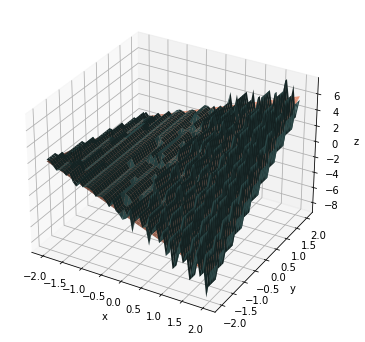

In [4]:
h = 0.00000000001
s = 0.00001
alpha = 1

fun = lambda x, y: y*(x+1)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x, y)
z_true = np.array(fun(np.ravel(X), np.ravel(Y)))
z_app = np.array(zeta3(np.ravel(X), np.ravel(Y)))
Z_true = z_true.reshape(X.shape)
Z_app = z_app.reshape(X.shape)

ax.plot_surface(X, Y, Z_true, color='darksalmon')
ax.plot_surface(X, Y, Z_app, color='darkslategrey')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [5]:
np.max(np.abs(Z_true - Z_app))

3.208698742799264

### Approximating $f(x)=1/x$
Notice that Lemma 4.5 only guarantees convergence on $L\subseteq (0,2)$, and that there will probably be an accumulated error. Especially near 0 and 2.

In [6]:
# Machine epsilon
7./3 - 4./3 - 1

2.220446049250313e-16

7.047072639144716
5.419597971657577
3.5714585704737987
2.399715484503454
2.138722179912947
2.1316832329816053
2.1316599588156775
2.131634327379815
2.13160879265548
2.131583257936696


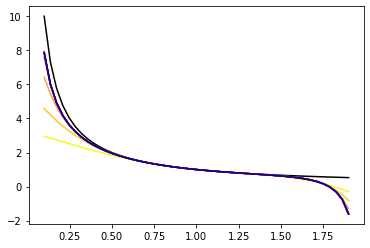

In [7]:
# Define mpfier
mpfier = mp.mpf(1)
mp.dps = 16 # Define the decimal precision.

# Initialize colors.
num_h_values = 10
cm_subset = np.linspace(1,0,num_h_values)
colors = [cm.plasma(x) for x in cm_subset]

# Initialize activation function.
rho = lambda x: x**2
d_rho = lambda x: 2*x

# Initialize constants.
h = 0.00001
s = 0.00001
alpha = 1

# Initialize first layer.
#x = mpfier * np.linspace(0.1,1.9)
x = np.linspace(0.1,1.9)
eta = (1-x)**2
zeta = 2-x

plt.plot(x, 1/x, color='black')

for i in range(num_h_values):
    eta_new = eta3(eta, zeta)
    zeta_new = zeta3(eta, zeta)
    
    # Test for numerical instability
    #eta_new = eta**2
    #zeta_new = zeta*(eta+1)
    
    eta = eta_new
    zeta = zeta_new

    print(np.max(np.abs(1/x - zeta)))
    
    plt.plot(x, zeta, color=colors[i])

plt.show()

52.6849195160266
50.363323548913755
41.18312312399555
34.071574699932725
29.41520429858575
26.0711592083896
23.536214163546205
21.54006674366862
19.922954678343036
18.583676582938825


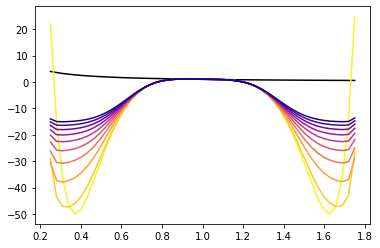

In [8]:
# Initialize colors.
num_h_values = 10
cm_subset = np.linspace(1,0,num_h_values)

colors = [cm.plasma(x) for x in cm_subset]

rho = lambda x: x**2
d_rho = lambda x: 2*x

h = 0.000000001
s = 0.00001
alpha = 0.0000001

# Initialize first layer.
x = np.linspace(0.25,1.75)

eta = (1-x)**2
zeta = 2-x

plt.plot(x, 1/x, color='black')

for i in range(num_h_values):
    eta_new = eta3(eta, zeta)
    zeta_new = zeta3(eta, zeta)
    
    # Test for numerical instability
    #eta_new = eta**2
    #zeta_new = zeta*(eta+1)
    
    eta = eta_new
    zeta = zeta_new

    print(np.max(np.abs(1/x - zeta)))
    
    plt.plot(x, zeta, color=colors[i])

plt.show()

### Choosing optimal values of $h$ and $s$ for fixed $\alpha$
To choose the optimal values of $h$ and $s$, we make a gridsearch, for fixed number of layers $n$ and $\alpha=1$.
We will not be using mpmath.

Remember to compare best values, for different values of $n$.

In [9]:
# Define function for calculating approximation to 1/x, using kappa_{h,s} n times

def reciprocal_dnn(x, h, s, alpha, n):
    ## Define functions, with correct constants
    # Define I_h (as in 'activation_functions.ipynb')
    rho = lambda x: x**2
    d_rho = lambda x: 2*x

    phi_h = lambda x: h*x + alpha
    psi_h = lambda x: (x - rho(alpha))/(h*d_rho(alpha))

    I_h = lambda x: psi_h(rho(phi_h(x)))

    # Define functions.
    eta1 = lambda x, y: I_h(x)
    zeta1 = lambda x, y: rho(x+s*y+1)

    eta2 = lambda x, y: rho(eta1(x,y))
    zeta2 = lambda x, y: I_h(zeta1(x,y) - 2*eta1(x,y) - 1)

    eta3 = lambda x, y: I_h(eta2(x,y))
    zeta3 = lambda x, y: I_h((zeta2(x,y)-eta2(x,y))/(2*s))
    
    # Initialize first layer.
    eta = (1-x)**2
    zeta = 2-x
    
    # Compose with kappa_{h,s} n times.
    for i in range(n):
        eta_new = eta3(eta, zeta)
        zeta_new = zeta3(eta, zeta)
    
        eta = eta_new
        zeta = zeta_new
        
    return(zeta)

In [10]:
def add_point(ax, x, y, z, fc = None, ec = None, radius = 0.005, name='NO LABEL'):
    """
    Plots point in the foreground of 3D matplotlib ax.
    """
    xy_len, z_len = ax.get_figure().get_size_inches()
    axis_length = [x[1] - x[0] for x in [ax.get_xbound(), ax.get_ybound(), ax.get_zbound()]]
    axis_rotation =  {'z': ((x, y, z), axis_length[1]/axis_length[0]),
                    'y': ((x, z, y), axis_length[2]/axis_length[0]*xy_len/z_len),
                    'x': ((y, z, x), axis_length[2]/axis_length[1]*xy_len/z_len)}
    for a, ((x0, y0, z0), ratio) in axis_rotation.items():
        if a=='z':
            p = Ellipse((x0, y0), width = radius, height = radius*ratio, fc=fc, ec=ec, label=name)
        else:
            p = Ellipse((x0, y0), width = radius, height = radius*ratio, fc=fc, ec=ec)
        ax.add_patch(p)
        art3d.pathpatch_2d_to_3d(p, z=z0, zdir=a)

In [11]:
%%time

# Define mpfier
mp.dps = 20

# Initialize constants.
h_vals = np.logspace(-1,-13,num=13)
s_vals = np.logspace(-1,-13,num=13)
alpha = 1
n = 4
x = np.linspace(1.25,1.75)

# Initialize error array.
err = np.zeros((len(h_vals), len(s_vals)))

# Calculate true values.
reci_x = 1/x

for i, h in enumerate(h_vals):
    for j, s in enumerate(s_vals):
        reci_dnn = reciprocal_dnn(x, h, s, alpha, n)
        err[i,j] = np.max(np.abs(reci_x - reci_dnn))
        

min_index = (err == err.min()).nonzero()

# Store (h*,s*)
h_star = h_vals[min_index[0]]
s_star = s_vals[min_index[1]]

print(min_index)

(array([7]), array([3]))
CPU times: user 104 ms, sys: 2.7 ms, total: 106 ms
Wall time: 106 ms


<ipython-input-9-94760b0242e9>:6: RuntimeWarning: overflow encountered in square
  rho = lambda x: x**2
<ipython-input-9-94760b0242e9>:22: RuntimeWarning: overflow encountered in true_divide
  zeta3 = lambda x, y: I_h((zeta2(x,y)-eta2(x,y))/(2*s))
<ipython-input-9-94760b0242e9>:10: RuntimeWarning: overflow encountered in true_divide
  psi_h = lambda x: (x - rho(alpha))/(h*d_rho(alpha))


In [12]:
# Remove inf and nan values.
err[~np.isfinite(err)] = np.inf

# Remove values that are too high to be interesting.
err[err>1e2] = np.inf

Minimum error:  0.0003772742777599092
(array([7]), array([3]))


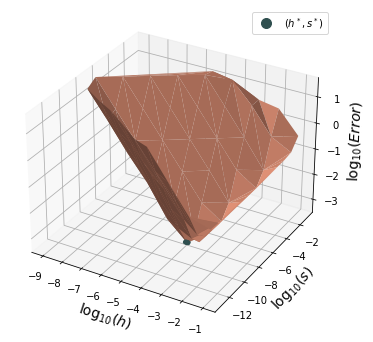

In [13]:
# Plot errors below 1.

print('Minimum error: ', np.min(err))
print(min_index)

fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(h_vals, s_vals)
Z = err.reshape(X.shape)

# Log scale
X = np.log10(X)
Y = np.log10(Y)
Z = np.log10(Z)

# Remove all EXCEPTION NUMBERs
ii = np.isfinite(err)
xx = X[ii]
yy = Y[ii]
zz = np.log10(err[ii])

font = {'size'   : 14}

# Add surface plot.
ax.plot_trisurf(xx,yy,zz, color='darksalmon')

# Plot (h*,s*) and (h',s')
add_point(ax, np.log10(s_star), np.log10(h_star), np.log10(err[min_index]), 
          fc = 'darkslategrey', ec = 'darkslategrey', 
          radius = 0.3, name=r'$(h^*,s^*)$')

#ax.set_title(r'$\vert I(x) - r^2(x)\vert$ for $n=$'+str(n), **font)

ax.set_xlabel(r'$\log_{10}(h)$', **font)
ax.set_ylabel(r'$\log_{10}(s)$', **font)
ax.set_zlabel(r'$\log_{10}(Error)$', **font)

# Define legend with circles.
colors = ['darkslategrey']
texts = [r'$(h^*,s^*)$']
patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts))]

plt.legend(handles=patches)
plt.savefig("r_n1.pdf")
plt.show()


Minimum error over n:  0.0003772742777599092


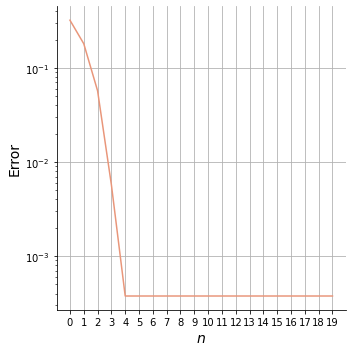

In [14]:
# Decreasing error by increasing n.

h_opt = h_vals[min_index[0]]
s_opt = s_vals[min_index[1]]
alpha = 1
num_n = 20
n_err = np.zeros(num_n)


for i, n in enumerate(np.arange(num_n)):
    reci_dnn = reciprocal_dnn(x, h_opt, s_opt, alpha, n)
    n_err[i] = np.max(np.abs(reci_x - reci_dnn))
    
print("Minimum error over n: ", np.min(n_err))
    
fig, ax = plt.subplots(figsize=(5,5))
    
ax.plot(range(num_n), n_err, color='darksalmon')


#ax.spines['left'].set_position('center')
#ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.grid()

ax.set_yscale('log')

ax.set_xlabel(r'$n$', **font)
ax.set_ylabel('Error', **font)

plt.xticks(np.arange(num_n))

plt.tight_layout()
plt.savefig("inverse_n_increase.pdf")

plt.show()

Minimum error over alpha:  0.0003772742777599092


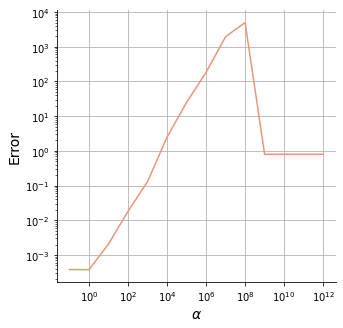

In [15]:
# Decreasing error by increasing alpha.

n = 4

h_opt = h_vals[min_index[0]]
s_opt = s_vals[min_index[1]]

num_alpha = 14
alpha_vals = np.logspace(-1, num_alpha-2, num=num_alpha)
alpha_err = np.zeros(num_alpha)


for i, alpha in enumerate(alpha_vals):
    reci_dnn = reciprocal_dnn(x, h_opt, s_opt, alpha, n)
    alpha_err[i] = np.max(np.abs(reci_x - reci_dnn))    

    
print("Minimum error over alpha: ", np.min(alpha_err))
    
# ......PLOT......
fig, ax = plt.subplots(figsize=(5,5))
    
ax.plot(alpha_vals, alpha_err, color='darksalmon')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.grid()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$\alpha$', **font)
ax.set_ylabel(r'Error', **font)

#plt.savefig("inverse_alpha_increase.pdf")

plt.show()

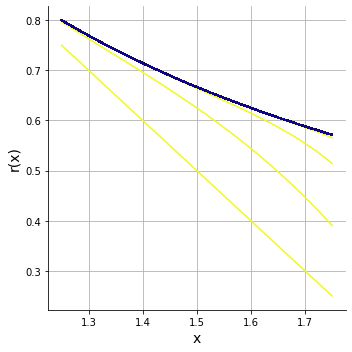

In [16]:
# Plot r for increasing n.


# Define constants.
h_opt = h_vals[min_index[0]]
s_opt = s_vals[min_index[1]]
alpha = 1
num_n = 1000

# Initialize colors.
cm_subset = np.linspace(1,0,num_n)
colors = [cm.plasma(x) for x in cm_subset]

fig, ax = plt.subplots(figsize=(5,5))

for i, n in enumerate(range(num_n)):
    reci_dnn = reciprocal_dnn(x, h_opt, s_opt, alpha, n)
    plt.plot(x, reci_dnn, color=colors[i], label=n)
    
    
#ax.spines['left'].set_position('center')
#ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.grid()


ax.set_xlabel('x', **font)
ax.set_ylabel('r(x)', **font)

#plt.legend()

plt.tight_layout()
#plt.savefig("inverse_n_increase.pdf")

plt.show()


# Approximating $I$ as $(1/(1/x))$

In [17]:
# Define reciprocal approximation
def reci(x, itt=10):
    # First layer.
    eta = (1-x)**2
    zeta = 2-x
    
    # Remaining layers.
    for i in range(itt):
        # New approximation.
        eta_new = eta3(eta, zeta)
        zeta_new = zeta3(eta, zeta)

        # Store new approximation.
        eta = eta_new
        zeta = zeta_new
    
    return zeta

In [18]:
x = np.linspace(0.25, 1.75)

h_opt = h_vals[min_index[0]]
s_opt = s_vals[min_index[1]]
alpha = 1
n = 4

# Calculate r^2
r = reciprocal_dnn(x, h_opt, s_opt, alpha, n)
r2 = reciprocal_dnn(r, h_opt, s_opt, alpha, n)

print(r2)

# Calculate error
print(np.max(np.abs(x - r2)))

[ 1.09262674e+55  1.00302562e+35  4.99308975e+26  8.84628250e+18
  3.47210082e+11  2.05796849e+06 -1.59541641e+03 -4.56684948e+01
 -4.74280881e-01  5.04957609e-01  5.55419244e-01  5.86558824e-01
  6.17346974e-01  6.48020104e-01  6.78457091e-01  7.09210468e-01
  7.39741601e-01  7.70272734e-01  8.01025912e-01  8.31557045e-01
  8.62199201e-01  8.92730334e-01  9.23261467e-01  9.54014645e-01
  9.84767823e-01  1.01529896e+00  1.04594111e+00  1.07669430e+00
  1.10733646e+00  1.13797861e+00  1.16873179e+00  1.19926292e+00
  1.22979406e+00  1.26032519e+00  1.29085632e+00  1.32183154e+00
  1.35180757e+00  1.38267177e+00  1.41331392e+00  1.44406710e+00
  1.47493130e+00  1.50512937e+00  1.53566050e+00  1.56663572e+00
  1.59672277e+00  1.62792003e+00  1.65911730e+00  1.68975945e+00
  1.71918036e+00  1.75048865e+00]
1.0926267374192113e+55


In [19]:
# Initialization.
h = 0.000001
s = 0.0001
alpha = 1
itt = 3
x = np.linspace(0.5,1.5)

# Square activation funtion.
rho = lambda x: x**2
d_rho = lambda x: 2*x

# Calculate reciprocal.
reci_x = reci(x, itt=itt)
I_reci_x = reci(reci_x, itt=itt)

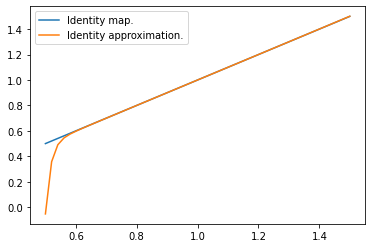

In [20]:
title = "Approximation. Itt = ?, error = ?"

plt.plot(x, x, label="Identity map.")
plt.plot(x, I_reci_x, label="Identity approximation.")

plt.legend()
plt.show()

**Take aways:**
- For 1 itteration (with low *h* and *s*) we get decent approximation, but more itterations just make it worse.
    - Unless we have larger value of $\alpha$.
- Not trivial to get a good approximation of I (even if we just have $R^2$).
- What if we use an 'mpfier'?

3.1573064819473693


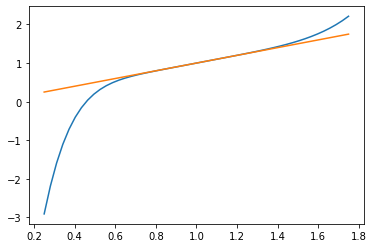

In [21]:
# Initialization.
h = 0.000001
s = 0.0001
alpha = 1
n = 1
x = np.linspace(0.25,1.75)

# Square activation funtion.
rho = lambda x: x**2
d_rho = lambda x: 2*x

# Calculate reciprocal.
reci_x = reciprocal_dnn(x, h, s, alpha, n)
I_reci_x = reciprocal_dnn(reci_x, h, s, alpha, n)

plt.plot(x, I_reci_x)
plt.plot(x, x)

print(np.max(np.abs(I_reci_x - x)))

### Approximating $x\mapsto 1/(1/x)$ with $r^2$ - illustrations for $n=1$ and $n=2$

In [22]:
import warnings
warnings.filterwarnings('ignore')

# ::: Grid search for chosen n (and fixed alpha) :::

n = 4

# Initialize constants.
h_vals = np.logspace(-1,-13,num=13)
s_vals = np.logspace(-1,-13,num=13)
alpha = 1
x = np.linspace(1.25,1.75)

# Initialize error array.
err = np.zeros((len(h_vals), len(s_vals)))

for i, h in enumerate(h_vals):
    for j, s in enumerate(s_vals):
        r = reciprocal_dnn(x, h, s, alpha, n)
        r2 = reciprocal_dnn(r, h, s, alpha, n)
        err[i,j] = np.max(np.abs(r2 - x))
        
# Remove nan values
err[np.isnan(err)] = np.inf

# Store (h', s')
min_index_n1 = (err == err.min()).nonzero()
h_prime = h_vals[min_index_n1[0]]
s_prime = s_vals[min_index_n1[1]]

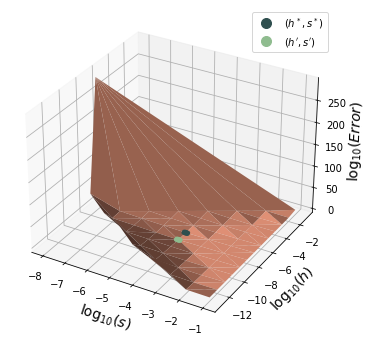

Error at (h*,s*):  [0.0010338]
Error at (h',s'):  [0.0010338]


In [23]:
# Surface plot of error.
fig = plt.figure(figsize=(6,6))

font = {'size'   : 14}

ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(h_vals, s_vals)
Z = err.reshape(X.shape)

# Log scale
X = np.log10(X)
Y = np.log10(Y)
Z = np.log10(Z)

# Remove all EXCEPTION NUMBERs
ii = np.isfinite(err)
xx = X[ii]
yy = Y[ii]
zz = np.log10(err[ii])

# Remove largest values
# zz[zz>0] = np.inf

# Add surface plot.
ax.plot_trisurf(xx,yy,zz, color='darksalmon')

# Plot (h*,s*) and (h',s')
add_point(ax, -4, -7, np.log10(err[min_index]), 
          fc = 'darkslategrey', ec = 'darkslategrey', 
          radius = 0.3, name=r'$(h^*,s^*)$') 

add_point(ax, np.log10(s_prime), np.log10(h_prime), 
          np.log10(err[min_index_n1]), fc = 'darkseagreen', 
          ec = 'darkseagreen', radius = 0.3, name=r'$(h^\prime ,s^\prime )$')

#ax.set_title(r'$\vert I(x) - r^2(x)\vert$ for $n=$'+str(n), **font)
ax.set_xlabel(r'$\log_{10}(s)$', **font)
ax.set_ylabel(r'$\log_{10}(h)$', **font)
ax.set_zlabel(r'$\log_{10}(Error)$', **font)

# Define legend with circles.
colors = ['darkslategrey', 'darkseagreen']
texts = [r'$(h^*,s^*)$', r'$(h^\prime ,s^\prime )$']
patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]

plt.legend(handles=patches)
plt.savefig("r2_n4.pdf")
plt.show()

print('Error at (h*,s*): ', err[min_index])
print('Error at (h\',s\'): ', err[min_index_n1])

In [24]:
min_index_n1

(array([7]), array([3]))

### Illustrating the accumulated error
$I_h$ is a decent approximation to the identity function, but there is a small error and as $t$ increases we see that 
\begin{align}
E_t = \vert I(x) - (I_h)^t(x) \vert
\end{align}
increases as well. The error as a function of $t$ and $x$ is illustrated below for $h=0.1$ and $\rho(x) = x^2$.

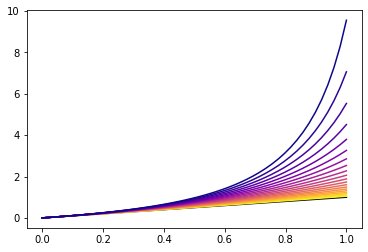

In [26]:
# Initialize colors.
num_h_values = 20
cm_subset = np.linspace(1,0,num_h_values)

colors = [cm.plasma(x) for x in cm_subset]

# Initialize values.
rho = lambda x: x**2
d_rho = lambda x: 2*x

h = 0.1
x = np.linspace(0, 1)
t = np.linspace(0, 1)

plt.plot(x, t, color='black')

for i in range(20):
    t = I_h(t)
    plt.plot(x, t, color=colors[i])

## Approximating $f(x,y) = xy$ with DNN

In [27]:
# Define I_h (as in 'activation_functions.ipynb')
rho = lambda x: x**2
d_rho = lambda x: 2*x

phi_h = lambda x: h*x + alpha
psi_h = lambda x: (x - rho(alpha))/(h*d_rho(alpha))

I_h = lambda x: psi_h(rho(phi_h(x)))


# Define variables
x = np.linspace(-2,2)
y = np.linspace(-2,2)

# Define the network
def xy_dnn(x,y):
    y11 = I_h(x)
    y12 = I_h(y)
    y13 = rho(x+y)

    y23 = rho(y11-y12)
    y24 = I_h(1/4*y13)

    out = y24 - 1/4*y23
    
    return out

In [28]:
alpha = 1
h = 0.0000000001
error = np.max(np.abs(x*y - xy_dnn(x,y)))
error

1.01019774434441e-06